# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 7.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 3.98MB/s]


# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [53]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    
    pred_loss = dev(dv_set, model, device)
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Validation Loss: {:4f}'.format(pred_loss))
    plt.show()
print('currently use device: ' + get_device())

currently use device: cuda


# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [80]:
select_feats = list(range(12))
all_feature = list(range(40)) + [57, 75]
for day in range(3): 
  all_feature += [ 40 + 18 * day + feat for feat in select_feats ]

class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # extract needed feature indexes
        feats = []
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = all_feature

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets => Ratio: 0.1
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.__normalize_feature()

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __normalize_feature(self):
        sample_mean = self.data[:, 40:].mean(dim=0, keepdim=True)
        sample_std = self.data[:, 40:].std(dim=0, keepdim=True)
        self.data[:, 40:] = (self.data[:, 40:] - sample_mean) / sample_std 

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

# K-fold Corss Validation DataSet

In [81]:
class COVID19TrainDataset(Dataset):
    def __init__(self, path, indices=None, select_feature=False):
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # select feature
        feats = list(range(93)) if not select_feature else all_feature
        self.feats_num = len(feats)

        self.data = torch.FloatTensor(data[:, feats])
        self.target = torch.FloatTensor(data[:, -1])

        if indices:
            self.data = self.data[indices]
            self.target = self.target[indices]
            self.__normalize_feature()

    def __normalize_feature(self):
        sample_mean = self.data[:, 40:].mean(dim=0, keepdim=True)
        sample_std = self.data[:, 40:].std(dim=0, keepdim=True)
        self.data[:, 40:] = (self.data[:, 40:] - sample_mean) / sample_std 

    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)

def create_cross_validation_datasets(path, fold_nums=5, select_feature=False):
    train_set = []
    all_data = COVID19TrainDataset(path)
    data_num = len(all_data)
    data_idx = np.arange(data_num)
    np.random.shuffle(data_idx)
    data_idx = data_idx.tolist()

    start = 0
    data_num_fold = data_num // fold_nums
    for fold_idx in range(fold_nums):
        start = fold_idx * data_num_fold
        end = min(start + data_num_fold, data_num)

        train_idx = data_idx[:start] +  data_idx[end:]
        val_idx = data_idx[start:end]

        train_data = COVID19TrainDataset(path, indices=train_idx, select_feature=select_feature)
        val_data = COVID19TrainDataset(path, indices=val_idx, select_feature=select_feature)

        train_set.append((train_data, val_data))
        
        print('fold {:2d} => train size: {:4d} val size {:4d}'.format(fold_idx, len(train_data), len(val_data)))

    return train_set

In [62]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'),
        drop_last=False,
        num_workers=n_jobs, 
        pin_memory=True
    )                            # Construct dataloader
    return dataloader

def create_dataloader(dataset, batch_size, mode='train', n_jobs=0):
    return DataLoader(
    dataset, batch_size,
    shuffle=(mode == 'train'),
    drop_last=False,
    num_workers=n_jobs, 
    pin_memory=True
    )                     
    return dataloader


# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [127]:
class ModelBase(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, name="model_base"):
        super().__init__()
        self.name = name
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

    def clear_weight(self):
        self.apply(self.__reset_weight)

    def __reset_weight(self, layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

class Model1(ModelBase):
    def __init__(self, input_dim):
        super().__init__(name="Linear64(1)")
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

class Model2(ModelBase):
    def __init__(self, input_dim):
        super().__init__(name="Linear32(2)")
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

class Model3(ModelBase):
    def __init__(self, input_dim):
        super().__init__(name="Linear32(3)")
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

class Model4(ModelBase):
    def __init__(self, input_dim):
        super().__init__(name="LinearNorm64(1)")
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

# **Train/Dev/Test**

## **Training**

In [122]:
def train(tr_set, dv_set, model, config, device, print_log=False):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs
    early_stops = config['early_stop']
    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = float("inf")
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0

    save_count = 0
    while epoch < n_epochs and early_stop_cnt <= early_stops:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
            save_count += 1

            if print_log and save_count % 10 == 1:
                print('Saving model (epoch = {:4d}, train_loss={:.4f}, val_loss = {:.4f})'.format(epoch + 1, loss_record['train'][-1] ,min_mse))

        else:
            early_stop_cnt += 1

        loss_record['dev'].append(dev_mse)
            
        epoch += 1
        

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [17]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [85]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'weight_decay': 0.1,
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 50,               # early stopping epochs (the number epochs since your model's last improvement)
}

# **Load data and model**

In [128]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)

model = Model3(tr_set.dataset.dim).to(device)  # Construct model and move to device
print("Model name: {model_name}, Input Dimension: {input}".format(model_name=model.name, input=tr_set.dataset.dim))

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 78)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 78)
Model name: Linear32(3), Input Dimension: 78


# **Start Training!**

Saving model (epoch =    1, train_loss=327.5587, val_loss = 320.2340)
Saving model (epoch =   12, train_loss=22.5970, val_loss = 25.3609)
Saving model (epoch =   22, train_loss=11.0331, val_loss = 12.7361)
Saving model (epoch =   32, train_loss=4.6338, val_loss = 4.0787)
Saving model (epoch =   42, train_loss=2.2668, val_loss = 1.8566)
Saving model (epoch =   53, train_loss=1.7303, val_loss = 1.3619)
Saving model (epoch =   70, train_loss=1.4846, val_loss = 1.1298)
Saving model (epoch =   90, train_loss=1.3041, val_loss = 1.0103)
Saving model (epoch =  130, train_loss=0.9886, val_loss = 0.8866)
Saving model (epoch =  165, train_loss=0.8319, val_loss = 0.8165)
Saving model (epoch =  337, train_loss=0.6777, val_loss = 0.7653)
Finished training after 1000 epochs


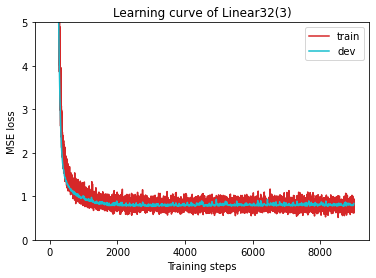

In [129]:
config['save_path'] = 'models/{model_name}.pth'.format(model_name=model.name)
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device, print_log=True)
plot_learning_curve(model_loss_record, title=model.name)

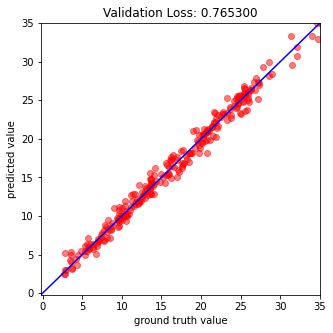

In [130]:
model.clear_weight()
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

# Train by cross validation



Training Helper Functions


In [103]:
def train_by_cross_val(train_sets, model, config, save_folder):
    train_history = {}
    for fold_idx, train_set in enumerate(train_sets):
        print("Start traing fold {:2d}".format(fold_idx))

        model.clear_weight()
        
        train_loader = create_dataloader(train_set[0], batch_size=config['batch_size'], mode='train')
        val_loader = create_dataloader(train_set[1], config['batch_size'], mode='val')

        # model = NeuralNet(input_dim=train_set[0].data.shape[1]).to(config['device'])
        config['save_path'] = os.path.join(save_folder, 'model_{:d}.pth'.format(fold_idx))
        model_loss, model_loss_record = train(train_loader, val_loader, model, config, device, print_log=False)
        train_history[fold_idx] = {
            'loss': model_loss,
            'record': model_loss_record,
            'model_path': config['save_path'],
        }
        print('Finish training fold {:2d} => val_loss: {:4f}'.format(fold_idx, model_loss))
    return train_history

def get_average_loss(train_history):
    total_loss = 0.
    for fold_idx, history in train_history.items():
        total_loss += history['loss']
    return total_loss / len(train_history)



In [104]:
device = get_device()  
select_feature = True             

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'device': device,

    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader

    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'weight_decay': 0.1,
    },
    
    'early_stop': 50,               # early stopping epochs (the number epochs since your model's last improvement)
}

train_sets = create_cross_validation_datasets(tr_path, fold_nums=5, select_feature = select_feature)

fold  0 => train size: 2160 val size  540
fold  1 => train size: 2160 val size  540
fold  2 => train size: 2160 val size  540
fold  3 => train size: 2160 val size  540
fold  4 => train size: 2160 val size  540


In [105]:
feats_num = train_sets[0][0].feats_num
model = Model3(feats_num).to(device)
print("Model name: {model_name}, Input Dimension: {input}".format(model_name=model.name, input=feats_num))

save_folder = 'models/cross_val/{:s}'.format(model.name)
os.makedirs(save_folder, exist_ok=True)
train_history = train_by_cross_val(train_sets, model, config, save_folder)

average_loss = get_average_loss(train_history)
print('cross_loss: {:.4f}'.format(average_loss))

Model name: Linear16(2), Input Dimension: 93
Start traing fold  0
Finished training after 442 epochs
Finish training fold  0 => val_loss: 1.443707
Start traing fold  1
Finished training after 504 epochs
Finish training fold  1 => val_loss: 1.023922
Start traing fold  2
Finished training after 569 epochs
Finish training fold  2 => val_loss: 0.810541
Start traing fold  3
Finished training after 690 epochs
Finish training fold  3 => val_loss: 0.914553
Start traing fold  4
Finished training after 462 epochs
Finish training fold  4 => val_loss: 1.169616
cross_loss: 1.0725


plot traing curve


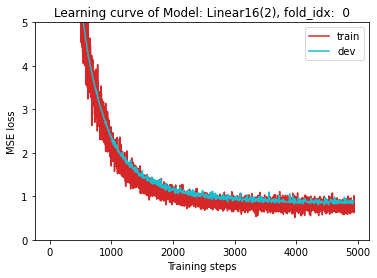

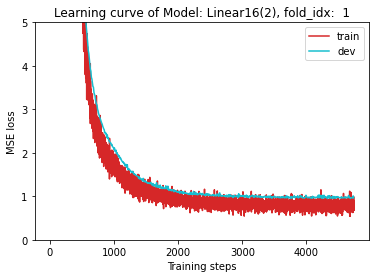

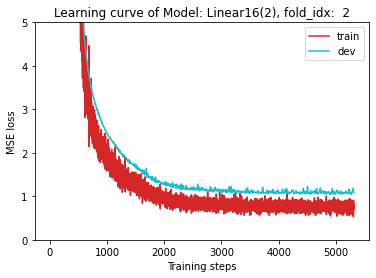

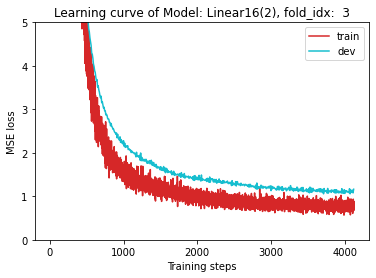

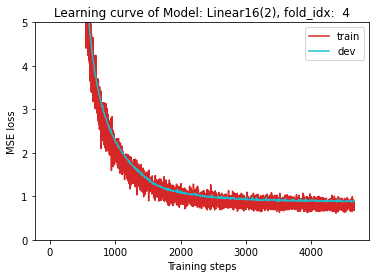

In [99]:
nums_fold = len(train_history)
for fold_idx, history in train_history.items():
  model_loss_record = history['record']

  plot_learning_curve(model_loss_record, title='Model: {:s}, fold_idx: {:2d}'.format(model.name, fold_idx))


# Final Training

Finished training after 1000 epochs


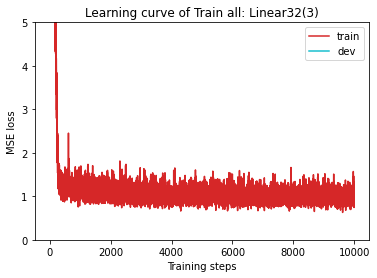

In [132]:
device = get_device()  
select_feature = True   

config = {
    'device': device,

    'n_epochs': 1000,         
    'batch_size': 270,
    'early_stop': 1000,

    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'weight_decay': 0.1,
    },
}


train_dataset = COVID19TrainDataset(path=tr_path, select_feature=select_feature)
validation_dataset = COVID19TrainDataset(path=tr_path, indices=[1], select_feature=select_feature)

train_loader = create_dataloader(train_dataset, batch_size=config['batch_size'], mode='train')
validation_loader = create_dataloader(validation_dataset, batch_size=config['batch_size'], mode='val')

model = Model3(train_dataset.feats_num).to(device)
loss, model_loss_record = train(train_loader, validation_loader, model, config, device, print_log=True)
plot_learning_curve(model_loss_record, title='Train all: {:s}'.format(model.name))

# Testing

In [133]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=select_feature)
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 78)
Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
